In [1]:
%pip install yfinance

Note: you may need to restart the kernel to use updated packages.


                   Sector  Beta (ΔYield)     t-stat        p-value  R-squared
4         Utilities (XLU)      -0.003165  -0.969252   3.324783e-01   0.000236
3  Consumer Staples (XLP)       0.020892   8.228696   2.536407e-16   0.016708
0        Technology (XLK)       0.052123  13.150708   1.066773e-38   0.041593
1        Financials (XLF)       0.088760  23.037813  2.353426e-110   0.117531
2            Energy (XLE)       0.093981  19.240460   5.841815e-79   0.085001


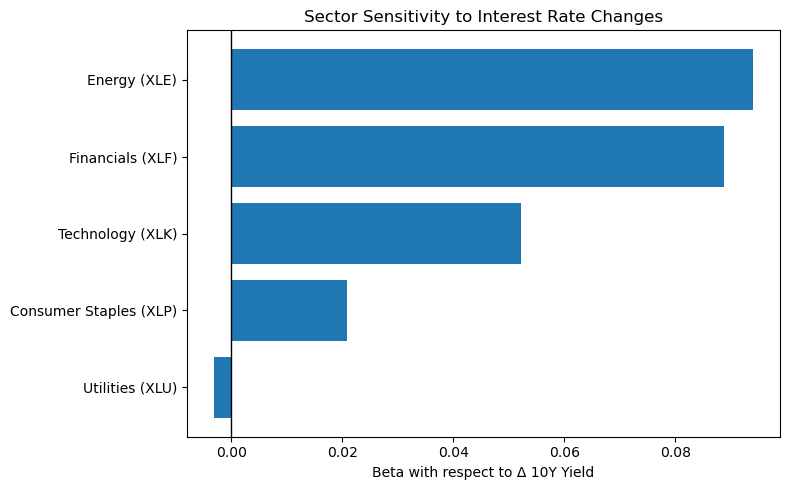

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from pandas_datareader import data as web
import statsmodels.api as sm

# ====== 1) Parameters ======
start = "2010-01-01"
end = None

sectors = {
    "Technology (XLK)": "XLK",
    "Financials (XLF)": "XLF",
    "Energy (XLE)": "XLE",
    "Consumer Staples (XLP)": "XLP",
    "Utilities (XLU)": "XLU"
}

# ====== 2) Load macro data (10Y yield) ======
rates = web.DataReader("DGS10", "fred", start, end)
rates = rates.dropna()
rates["dy"] = rates["DGS10"].diff()

# ====== 3) Load sector ETF prices ======
tickers = list(sectors.values())
raw = yf.download(tickers, start=start, auto_adjust=True, progress=False)
if isinstance(raw.columns, pd.MultiIndex):
    prices = raw["Close"]
else:
    prices = raw[["Close"]].rename(columns={"Close": tickers[0]})

prices = prices.dropna()

# ====== 4) Compute returns ======
returns = np.log(prices).diff()

# ====== 5) Align datasets ======
data = returns.join(rates["dy"], how="inner").dropna()

# ====== 6) Run regressions ======
results = []

for sector, ticker in sectors.items():
    y = data[ticker]
    X = sm.add_constant(data["dy"])
    model = sm.OLS(y, X).fit()
    
    results.append({
        "Sector": sector,
        "Beta (ΔYield)": model.params["dy"],
        "t-stat": model.tvalues["dy"],
        "p-value": model.pvalues["dy"],
        "R-squared": model.rsquared
    })

results_df = pd.DataFrame(results).sort_values("Beta (ΔYield)")

print(results_df)

# ====== 7) Visualization: sensitivity comparison ======
plt.figure(figsize=(8,5))
plt.barh(results_df["Sector"], results_df["Beta (ΔYield)"])
plt.axvline(0, color="black", linewidth=1)
plt.title("Sector Sensitivity to Interest Rate Changes")
plt.xlabel("Beta with respect to Δ 10Y Yield")
plt.tight_layout()
plt.show()